Model Params:
input_size:  7
hidden_size:  128
output_size:  1
num_layers:  2
learning_rate:  0.0001
num_epochs:  100
Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 1, 128], [-1, 2, 128]]               0
            Linear-2                    [-1, 1]             129
Total params: 129
Trainable params: 129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.25
Params size (MB): 0.00
Estimated Total Size (MB): 0.25
----------------------------------------------------------------
None


c:\Users\kh\Desktop\mbb_stock_prediction_analysis\venv\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([4855, 1, 1])) that is different to the input size (torch.Size([4855, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\kh\Desktop\mbb_stock_prediction_analysis\venv\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([1041, 1, 1])) that is different to the input size (torch.Size([1041, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Train Loss: 0.4187, Val Loss: 0.4155
Epoch [20/100], Train Loss: 0.3161, Val Loss: 0.3090
Epoch [30/100], Train Loss: 0.2306, Val Loss: 0.2194
Epoch [40/100], Train Loss: 0.1618, Val Loss: 0.1459
Epoch [50/100], Train Loss: 0.1078, Val Loss: 0.0889
Epoch [60/100], Train Loss: 0.0712, Val Loss: 0.0490
Epoch [70/100], Train Loss: 0.0497, Val Loss: 0.0253
Epoch [80/100], Train Loss: 0.0406, Val Loss: 0.0143
Epoch [90/100], Train Loss: 0.0381, Val Loss: 0.0106
Epoch [100/100], Train Loss: 0.0378, Val Loss: 0.0097


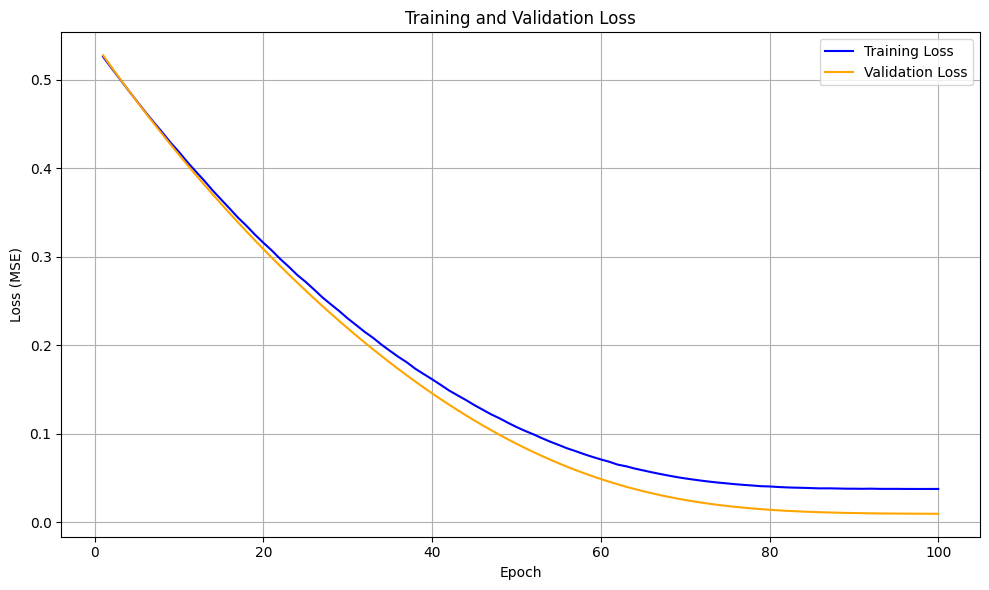

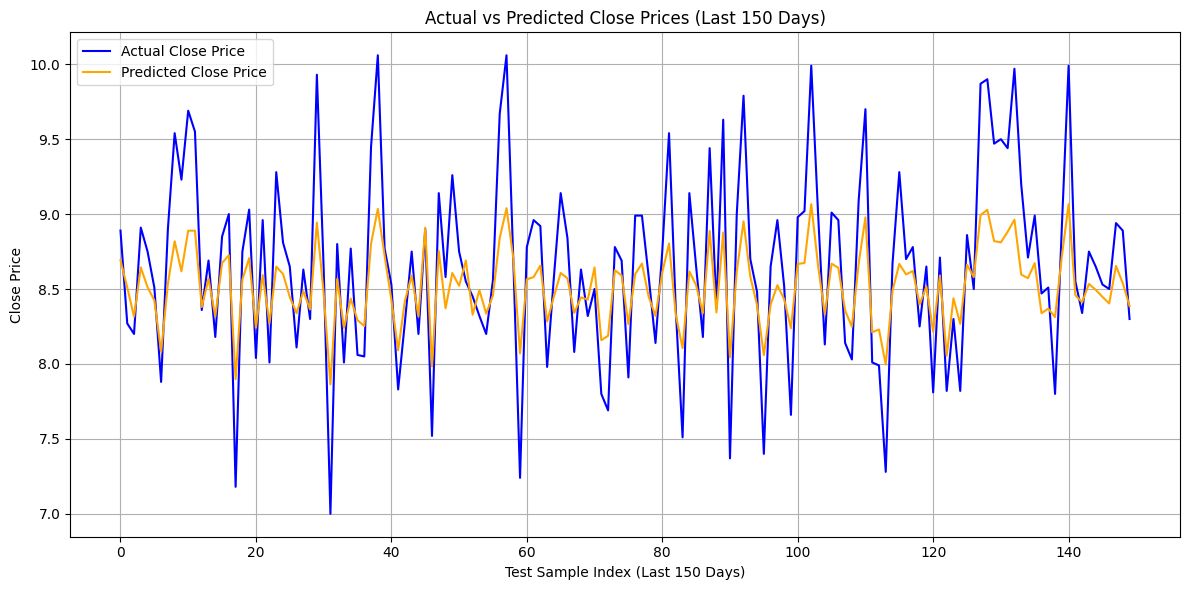

Evaluation metric:
MAE: 0.3288
MSE: 0.1703
RMSE: 0.4127
MAPE: 3.79%
R2 Score: 0.5758


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary  # For model summary
import joblib

# Step 1: Load data
data = pd.read_csv("data/selected_features_df.csv")
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.dropna(inplace=True)

# Step 2: Normalize features and target using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = scaler_X.fit_transform(data.drop(columns=['Close']))
y = scaler_y.fit_transform(data[['Close']])

# Step 3: Split data into train (70%), val (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to("cuda")
y_train = torch.tensor(y_train, dtype=torch.float32).to("cuda")
X_val = torch.tensor(X_val, dtype=torch.float32).to("cuda")
y_val = torch.tensor(y_val, dtype=torch.float32).to("cuda")
X_test = torch.tensor(X_test, dtype=torch.float32).to("cuda")
y_test = torch.tensor(y_test, dtype=torch.float32).to("cuda")

# Reshape X tensors to match RNN's expected input dimensions
X_train = X_train.unsqueeze(1)  # Add sequence length dimension
X_val = X_val.unsqueeze(1)
X_test = X_test.unsqueeze(1)

# Ensure target tensors are 2D
y_train = y_train.unsqueeze(1)
y_val = y_val.unsqueeze(1)
y_test = y_test.unsqueeze(1)

# Step 4: Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to("cuda")  # Initialize hidden state
        out, _ = self.rnn(x, h0)  # RNN layer
        out = self.fc(out[:, -1, :])  # Fully connected layer on the last time step
        return out

# Model hyperparameters
input_size = X_train.size(2)  # Input features (adjusted after unsqueeze)
hidden_size = 128
output_size = 1
num_layers = 2
learning_rate = 1e-4
num_epochs = 100

print("Model Params:")
print("input_size: ", input_size)
print("hidden_size: ", hidden_size)
print("output_size: ", output_size)
print("num_layers: ", num_layers)
print("learning_rate: ", learning_rate)
print("num_epochs: ", num_epochs)

# Initialize the model, loss function, and optimizer
model = RNNModel(input_size, hidden_size, output_size, num_layers).to("cuda")
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Print the model summary
print("Model Summary:")
print(summary(model, input_size=(1, input_size)))

# Initialize lists to store training and validation losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass for training
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    train_losses.append(loss.item())  # Store training loss
    loss.backward()
    optimizer.step()

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_losses.append(val_loss.item())  # Store validation loss
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_outputs = test_outputs.cpu().numpy()  # Convert predictions to numpy

# Inverse transform scaled data
test_outputs = scaler_y.inverse_transform(test_outputs.reshape(-1, 1))  # Reshape predictions to 2D
y_test_actual = scaler_y.inverse_transform(y_test.cpu().numpy().reshape(-1, 1))  # Reshape actual values to 2D

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_actual, test_outputs)
mse = mean_squared_error(y_test_actual, test_outputs)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_actual - test_outputs) / y_test_actual)) * 100
r2 = r2_score(y_test_actual, test_outputs)

# Plot training and validation losses
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", color="blue")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plot Actual vs Predicted Close Prices for the Last 250 Days
import matplotlib.pyplot as plt

# Limit data to the last 250 days
last_250_actual = y_test_actual[-150:]
last_250_predicted = test_outputs[-150:]

# Plot actual vs predicted close prices
plt.figure(figsize=(12, 6))
plt.plot(last_250_actual, label="Actual Close Price", color="blue", linewidth=1.5)
plt.plot(last_250_predicted, label="Predicted Close Price", color="orange", linestyle="-", linewidth=1.5)
plt.xlabel("Test Sample Index (Last 150 Days)")
plt.ylabel("Close Price")
plt.title("Actual vs Predicted Close Prices (Last 150 Days)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Print results
print("Evaluation metric:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R2 Score: {r2:.4f}")

# # Save the model and scalers
# torch.save(model.state_dict(), "trained_model/rnn/rnn_model.pth")
# joblib.dump(scaler_X, "trained_model/rnn/scaler_X.pkl")
# joblib.dump(scaler_y, "trained_model/rnn/scaler_y.pkl")


Model Params:
input_size: 7, hidden_size: 128
num_layers: 2, output_size: 1
learning_rate: 0.001, num_epochs: 100
Model Summary:
Layer (type:depth-idx)                   Output Shape              Param #
SimpleRNN                                [32, 1]                   --
├─RNN: 1-1                               [32, 1, 128]              50,560
├─Linear: 1-2                            [32, 1]                   129
Total params: 50,689
Trainable params: 50,689
Non-trainable params: 0
Total mult-adds (M): 1.62
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.20
Estimated Total Size (MB): 0.24
Epoch [10/100], Train Loss: 0.0514, Val Loss: 0.0553
Epoch [20/100], Train Loss: 0.0134, Val Loss: 0.0085
Epoch [30/100], Train Loss: 0.0139, Val Loss: 0.0039
Epoch [40/100], Train Loss: 0.0114, Val Loss: 0.0031
Epoch [50/100], Train Loss: 0.0078, Val Loss: 0.0026
Epoch [60/100], Train Loss: 0.0055, Val Loss: 0.0010
Epoch [70/100], Train Loss: 0.0039, Val Loss: 0.0007

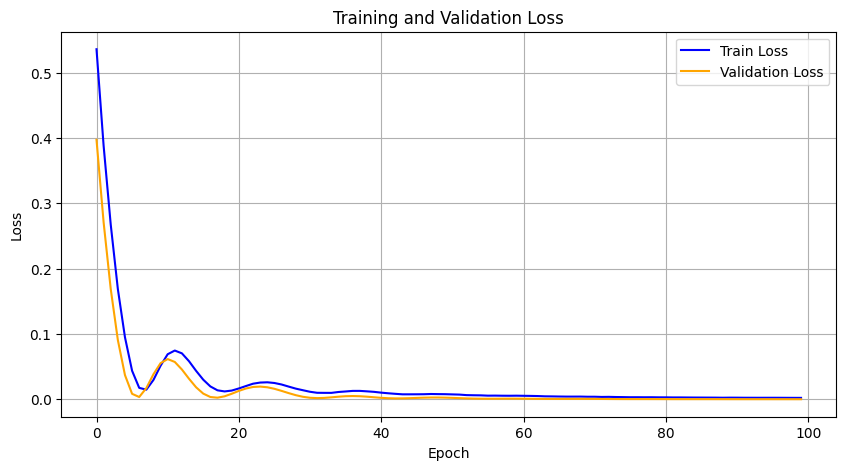

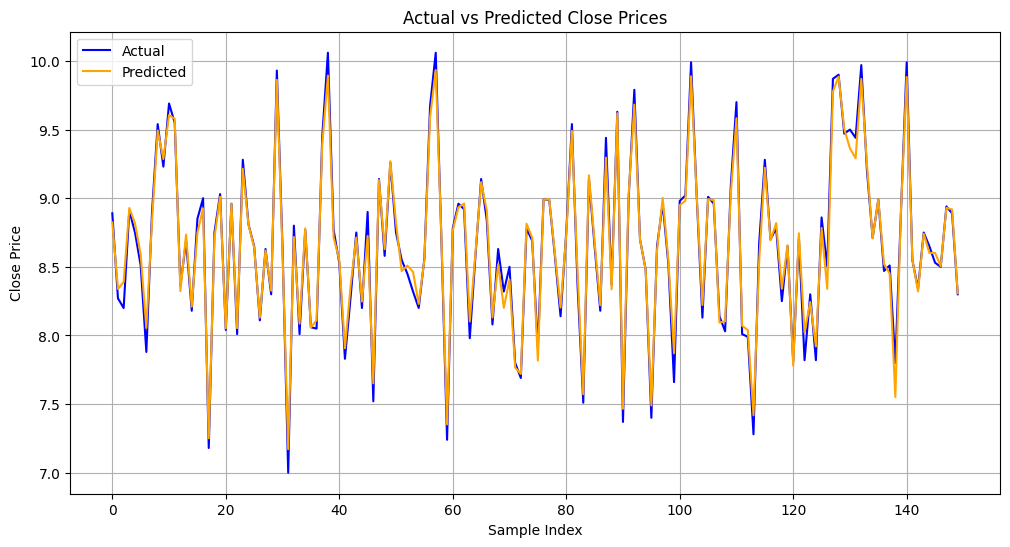

Re-evaluating Loaded Model:
MAE: 0.0613
MSE: 0.0072
RMSE: 0.0850
MAPE: 0.73%
R2 Score: 0.9820


['trained_model/rnn2/scaler_y.pkl']

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import joblib
from torchinfo import summary

# Step 1: Load data
data = pd.read_csv("data/selected_features_df.csv")
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.dropna(inplace=True)

# Step 2: Normalize features and target using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = scaler_X.fit_transform(data.drop(columns=['Close']))
y = scaler_y.fit_transform(data[['Close']])

# Step 3: Split data into train (70%), val (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert data to PyTorch tensors and reshape for RNN
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to("cuda")  # Add sequence dimension
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1).to("cuda")
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to("cuda")
y_train = torch.tensor(y_train, dtype=torch.float32).to("cuda")
y_val = torch.tensor(y_val, dtype=torch.float32).to("cuda")
y_test = torch.tensor(y_test, dtype=torch.float32).to("cuda")

# Step 4: Define RNN Model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)  # RNN layer
        out = self.fc(out[:, -1, :])  # Fully connected layer on the last time step
        return out

# Initialize model and hyperparameters
input_size = X_train.size(-1)  # Number of features
hidden_size = 128
num_layers = 2
output_size = 1
learning_rate = 1e-3
num_epochs = 100

print("Model Params:")
print(f"input_size: {input_size}, hidden_size: {hidden_size}")
print(f"num_layers: {num_layers}, output_size: {output_size}")
print(f"learning_rate: {learning_rate}, num_epochs: {num_epochs}")

model = SimpleRNN(input_size, hidden_size, num_layers, output_size).to("cuda")

# Print the model summary
print("Model Summary:")
print(summary(model, input_size=(32, 1, input_size), device="cuda"))  # Batch size = 32

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Step 5: Train the model
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()
    train_output = model(X_train)
    train_loss = criterion(train_output, y_train)
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        val_losses.append(val_loss.item())

    # Print losses every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", color="blue")
plt.plot(val_losses, label="Validation Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

# Step 6: Evaluate the model
model.eval()
with torch.no_grad():
    test_output = model(X_test).cpu().numpy()
    y_test_actual = scaler_y.inverse_transform(y_test.cpu().numpy())
    test_predictions = scaler_y.inverse_transform(test_output)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_actual, test_predictions)
mse = mean_squared_error(y_test_actual, test_predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_actual - test_predictions) / y_test_actual)) * 100
r2 = r2_score(y_test_actual, test_predictions)

# Step 7: Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual[-150:], label="Actual", color="blue")
plt.plot(test_predictions[-150:], label="Predicted", color="orange")
plt.xlabel("Sample Index")
plt.ylabel("Close Price")
plt.title("Actual vs Predicted Close Prices")
plt.legend()
plt.grid()
plt.show()

# Print results
print("Re-evaluating Loaded Model:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R2 Score: {r2:.4f}")

# Save model and scalers
torch.save(model.state_dict(), "trained_model/rnn2/rnn_model.pth")
joblib.dump(scaler_X, "trained_model/rnn2/scaler_X.pkl")
joblib.dump(scaler_y, "trained_model/rnn2/scaler_y.pkl")


In [5]:
# Load the saved model
loaded_model = RNNModel(input_size, hidden_size, output_size, num_layers).to("cuda")
loaded_model.load_state_dict(torch.load("trained_model/rnn2/rnn_model.pth"))
loaded_model.eval()

# Load the scalers
scaler_X = joblib.load("trained_model/rnn2/scaler_X.pkl")
scaler_y = joblib.load("trained_model/rnn2/scaler_y.pkl")
print("Model and scalers successfully loaded.")


Model and scalers successfully loaded.


C:\Users\kh\AppData\Local\Temp\ipykernel_15732\1566824779.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load("trained_model/rnn2/rnn

In [6]:
# Re-evaluate the loaded model
with torch.no_grad():
    # Add the sequence dimension for the test data
    test_outputs_loaded = loaded_model(X_test)
    
    # Remove extra dimensions and inverse scale the predictions
    test_outputs_loaded = scaler_y.inverse_transform(test_outputs_loaded.squeeze().cpu().numpy().reshape(-1, 1))
    y_test_actual = scaler_y.inverse_transform(y_test.squeeze().cpu().numpy().reshape(-1, 1))

# Calculate evaluation metrics for the loaded model
mae = mean_absolute_error(y_test_actual, test_outputs_loaded)
mse = mean_squared_error(y_test_actual, test_outputs_loaded)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_actual - test_outputs_loaded) / y_test_actual)) * 100
r2 = r2_score(y_test_actual, test_outputs_loaded)

# Print results
print("Re-evaluating Loaded Model:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R2 Score: {r2:.4f}")


Re-evaluating Loaded Model:
MAE: 0.0613
MSE: 0.0072
RMSE: 0.0850
MAPE: 0.73%
R2 Score: 0.9820


c:\Users\kh\Desktop\mbb_stock_prediction_analysis\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


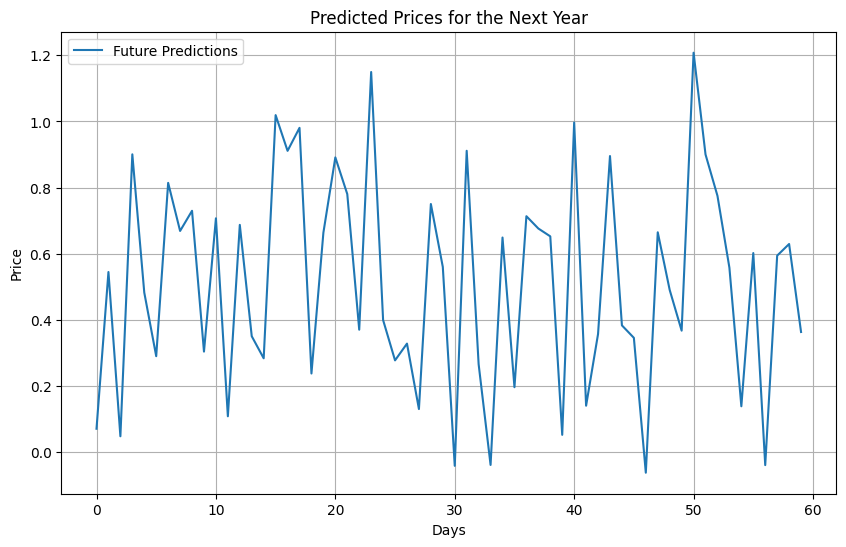

In [ ]:
# Simulate new data for the next year (365 days of random normalized input for demonstration)
future_data = np.random.random((60, X_train.size(2)))  # Random future input data
future_data_scaled = torch.tensor(scaler_X.transform(future_data), dtype=torch.float32).unsqueeze(1).to("cuda")

# Predict future prices
with torch.no_grad():
    future_predictions = loaded_model(future_data_scaled)
    future_predictions = scaler_y.inverse_transform(future_predictions.cpu().numpy())

# Plot future predictions
plt.figure(figsize=(10, 6))
plt.plot(future_predictions, label='Future Predictions')
plt.title("Predicted Prices for the Next Year")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()


In [11]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)  # RNN layer
        out = self.fc(out[:, -1, :])  # Fully connected layer on the last time step
        return out

Model and scalers successfully loaded.


C:\Users\kh\AppData\Local\Temp\ipykernel_15732\2972177207.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load("trained_model/rnn2/rnn

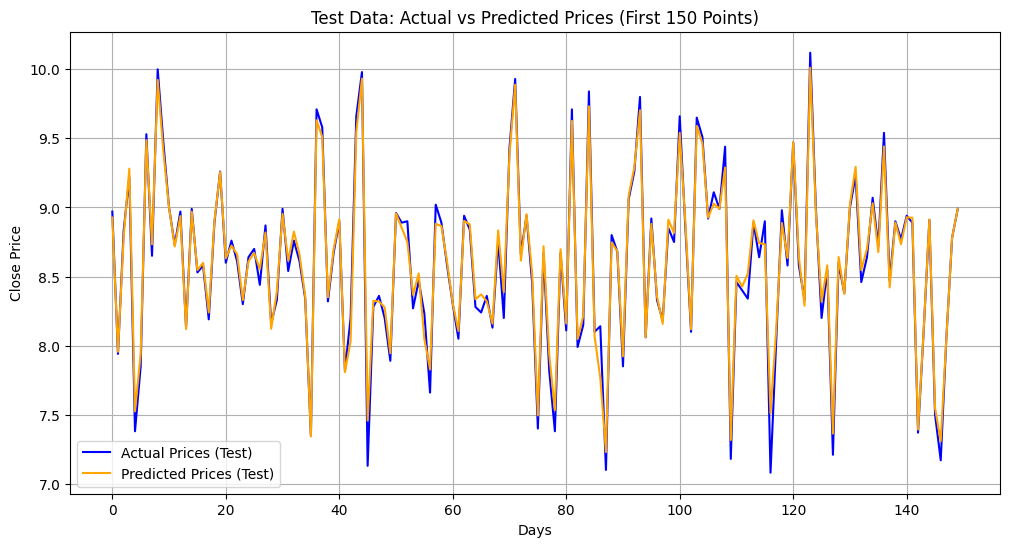

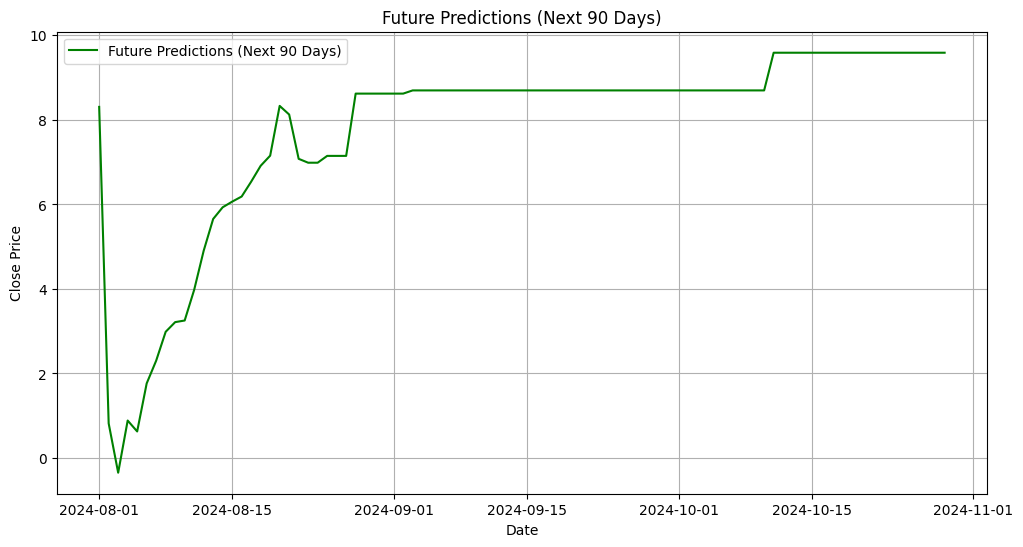

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import joblib

# Load the saved model
loaded_model = SimpleRNN(input_size, hidden_size, num_layers, output_size).to("cuda")
loaded_model.load_state_dict(torch.load("trained_model/rnn2/rnn_model.pth"))
loaded_model.eval()

# Load the scalers
scaler_X = joblib.load("trained_model/rnn2/scaler_X.pkl")
scaler_y = joblib.load("trained_model/rnn2/scaler_y.pkl")
print("Model and scalers successfully loaded.")

# Evaluate on test data (First 150 points)
with torch.no_grad():
    test_outputs = loaded_model(X_test[:150])  # Predict first 150 points
    test_predictions = scaler_y.inverse_transform(test_outputs.cpu().numpy())
    y_test_actual = scaler_y.inverse_transform(y_test[:150].cpu().numpy())

# Plot Test Data Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Prices (Test)', color='blue')
plt.plot(test_predictions, label='Predicted Prices (Test)', color='orange')
plt.title("Test Data: Actual vs Predicted Prices (First 150 Points)")
plt.xlabel("Days")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.show()

# Predict Future Prices (Next 90 Days)
future_predictions = []
future_input = X_test[-1].unsqueeze(0)  # Start with the last test input

for _ in range(90):  # Adjust to 90 days
    with torch.no_grad():
        # Predict the next day
        future_output = loaded_model(future_input)
        future_price = scaler_y.inverse_transform(future_output.cpu().numpy())  # Inverse transform
        future_predictions.append(future_price.squeeze())
        
        # Update the next input
        next_input = future_input.squeeze(0).cpu().numpy()
        next_input[:, -1] = future_price.squeeze()  # Update the last feature (Close Price)
        
        # Create a DataFrame to preserve feature names for the scaler
        next_input_df = pd.DataFrame(next_input, columns=data.drop(columns=['Close']).columns)
        next_input_scaled = scaler_X.transform(next_input_df)  # Scale the updated input
        future_input = torch.tensor(next_input_scaled, dtype=torch.float32).unsqueeze(0).to("cuda")

# Generate a new date range for future predictions
last_date = pd.to_datetime(data.index[-1])
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90, freq='D')

# Plot Future Predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions, label='Future Predictions (Next 90 Days)', color='green')
plt.title("Future Predictions (Next 90 Days)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.show()



[*********************100%%**********************]  1 of 1 completed


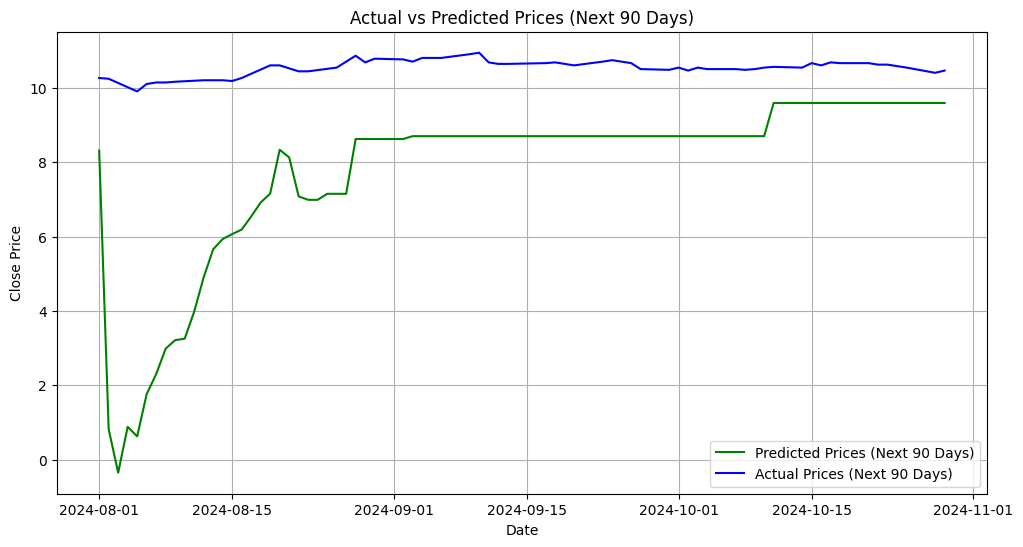

ValueError: Found input variables with inconsistent numbers of samples: [63, 90]

In [16]:
import yfinance as yf

# Fetch actual close prices from Yahoo Finance
symbol = "1155.KL"  # Replace with the correct stock ticker symbol
start_date = "2024-08-01"
end_date = "2024-10-30"  # 90 days after 2024-08-01

# Download the stock data
stock_data = yf.download(symbol, start=start_date, end=end_date)
actual_close_prices = stock_data["Close"].values
actual_dates = stock_data.index

# Ensure the actual close price data length matches predictions
actual_close_prices = actual_close_prices[:90]  # Limit to the first 90 days

# Plot Actual vs Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions, label='Predicted Prices (Next 90 Days)', color='green')
plt.plot(actual_dates, actual_close_prices, label='Actual Prices (Next 90 Days)', color='blue')
plt.title("Actual vs Predicted Prices (Next 90 Days)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.show()

mae = mean_absolute_error(actual_close_prices, future_predictions)
mse = mean_squared_error(actual_close_prices, future_predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_close_prices - future_predictions) / actual_close_prices)) * 100
r2 = r2_score(actual_close_prices, future_predictions)

# Print the Metrics
print("Evaluation Metrics:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

[*********************100%%**********************]  1 of 1 completed

Evaluation Metrics:
MAE: 1.3052
MSE: 1.8650
RMSE: 1.3657
MAPE: 12.38%
R²: -331.7191


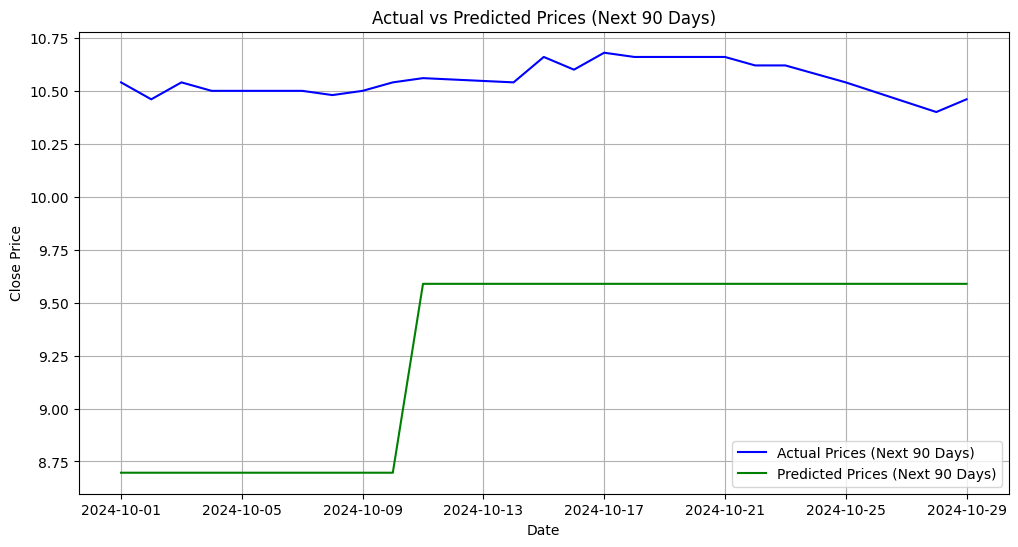

In [21]:
import yfinance as yf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Fetch actual close prices from Yahoo Finance
symbol = "1155.KL"  # Replace with the correct stock ticker symbol
start_date = "2024-10-01"
end_date = "2024-11-30"  # 90 days after 2024-08-01

# Download the stock data
stock_data = yf.download(symbol, start=start_date, end=end_date)
actual_close_prices = stock_data["Close"]
actual_dates = stock_data.index

# Ensure future_predictions has the same date range as actual_close_prices
# Filter future_predictions to align with available actual_dates
future_predictions_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted_Close": future_predictions
})
future_predictions_df.set_index("Date", inplace=True)

# Align actual and predicted data
aligned_actual = actual_close_prices[actual_close_prices.index.isin(future_predictions_df.index)]
aligned_predicted = future_predictions_df.loc[aligned_actual.index, "Predicted_Close"]

# Compute Evaluation Metrics
mae = mean_absolute_error(aligned_actual, aligned_predicted)
mse = mean_squared_error(aligned_actual, aligned_predicted)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((aligned_actual - aligned_predicted) / aligned_actual)) * 100
r2 = r2_score(aligned_actual, aligned_predicted)

# Print the Metrics
print("Evaluation Metrics:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

# Plot Actual vs Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(aligned_actual.index, aligned_actual, label='Actual Prices (Next 90 Days)', color='blue')
plt.plot(aligned_predicted.index, aligned_predicted, label='Predicted Prices (Next 90 Days)', color='green')
plt.title("Actual vs Predicted Prices (Next 90 Days)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.show()


In [ ]:
comparison_df = pd.DataFrame({
    "Date": aligned_actual.index,
    "Actual_Close": aligned_actual.values,
    "Predicted_Close": aligned_predicted.values
}).set_index("Date")

comparison_df.tail()

,Actual_Close,Predicted_Close
Date,,
2024-10-23,10.62,9.588797
2024-10-24,10.58,9.588797
2024-10-25,10.54,9.588797
2024-10-28,10.40,9.588797
2024-10-29,10.46,9.588797
